# Merged PG Analysis - 3 Species (Mtb, Ecoli, Saureus) comparison

### Import Statements

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
%reload_ext autoreload
%autoreload 2
    
from panqc.utils import parse_PresAbs_Rtab, get_PG_StatsDF_FromPresAbs

from panqc.utils import get_PG_Stats_FromPresAbs, get_PG_Stats_FromPresAbs_V2


# Define Functions

In [4]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [5]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [6]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [7]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Default_Content_TXT):
    with open(i_Ppanggolin_Default_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            line_split = line.split(": ")

            Key = line_split[0].split(" (")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)

        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

In [8]:

def calculate_gene_gain_loss_stats(branchstats_tsv):
    """
    Calculate gene gain and loss statistics for ancestral branches and tips
    from a branchstats.tsv file generated by Panstripe software.
    
    Parameters:
        branchstats_tsv (str): Path to the branchstats.tsv file.
        
    Returns:
        dict: A dictionary containing the four statistics:
              - N_Gain_AncBranches: Total number of genes gained on ancestral branches.
              - N_Loss_AncBranches: Total number of genes lost on ancestral branches.
              - N_Gain_Tips: Total number of genes gained on tips.
              - N_Loss_Tips: Total number of genes lost on tips.
    """
    # Load the data
    data = pd.read_csv(branchstats_tsv, sep="\t")
    
    # Split the data into ancestral branches and tips
    data_tips = data.query("istip == 1")
    data_ancs = data.query("istip == 0")
    
    # Calculate statistics
    stats = {
        "N_Gain_Ancs": data_ancs["acc_gain"].sum(),
        "N_Loss_Ancs": data_ancs["acc_loss"].sum(),
        "N_Gain_Tips": data_tips["acc_gain"].sum(),
        "N_Loss_Tips": data_tips["acc_loss"].sum()
    }
    
    return stats

# Example usage:
# file_path = "path/to/Panstripe.BranchStats.tsv"
# stats = calculate_gene_gain_loss_stats(file_path)
# print(stats)


In [9]:
def read_BaktaTXT_ToBasicInfoDict(i_BaktaInfo_TXT):
    """
    Function to read in a bakta.txt file. 
    
    The function extracts the following information & stores it as a dictionary:
    1) Total Cumulative Length (Across all contigs), 2) Number of contigs
    3) GC content, 4) Assembly N50, 5) Number CDS, 6) Coding Density
    """
    
    out_BaktaInfo_Dict = {}
    
    i_Asm_BaktaInfo_DF = pd.read_csv(i_BaktaInfo_TXT, sep = ":",header=None)
    i_Asm_BaktaInfo_RawDict = dict(i_Asm_BaktaInfo_DF[[0,1]].values)

    out_BaktaInfo_Dict["TotalContigLength"] = int(i_Asm_BaktaInfo_RawDict["Length"])
    out_BaktaInfo_Dict["NumContigs"] = int(i_Asm_BaktaInfo_RawDict["Count"])
    out_BaktaInfo_Dict["GCcontent"] = float(i_Asm_BaktaInfo_RawDict["GC"] )
    out_BaktaInfo_Dict["N50"] = float(i_Asm_BaktaInfo_RawDict["N50"])
    out_BaktaInfo_Dict["NumCDS"] = int( i_Asm_BaktaInfo_RawDict["CDSs"])

    out_BaktaInfo_Dict["CodingDensity"] = float(i_Asm_BaktaInfo_RawDict["coding density"])
    out_BaktaInfo_Dict["NumHypotheticals"] = int(i_Asm_BaktaInfo_RawDict['hypotheticals'])

    
    return out_BaktaInfo_Dict


# Define paths to metadata & pipeline outputs (All 3 Species)

In [10]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"


### Mtb PG Analysis Files ###

Mtb_WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = Mtb_WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

Mtb_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir
############################################################




### Ecoli PG Analysis Files ###

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Ecoli_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"
PG_Ecoli_50I_OutDir = Ecoli_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"



Ecoli_Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

Shaw2021_50Asm_Dir = f"{Ecoli_Data_MainDir}/Shaw2021.50Genomes.Data/data"
Shaw2021_Meta_TSV = f"{Ecoli_Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

Ecoli_Meta_Dir = f"../../Data/230905_Ecoli_50CI_Metadata_Shaw2021"  

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{Ecoli_Meta_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"



############################################################


### Saureus PG Analysis Files ###

SA_PG_MainDir = f"{Proj_MainDir}/241206_Saureus_PG_Analysis"  

SA_SMK_Outputs_Dir = f"{SA_PG_MainDir}/SMK_OutDirs"

PG_SA_68I_OutDir = SA_SMK_Outputs_Dir + "/241206_Saureus_HoutakBouras2023_68I_V1"



SA_Data_MainDir = f"{SA_PG_MainDir}/Data"  

SA_68CI_GenomeFASTAs_Dir = f"{SA_Data_MainDir}/CRS.Saureus.68CI.GenomesFromGitRepo"

HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV = f"{SA_PG_MainDir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"

Saureus_Repo_Meta_Dir = f"../../Data/241206_Saureus_HoutakBouras2023_Metadata"  

Sa_ENA_RunData_TSV = f"{Saureus_Repo_Meta_Dir}/ENA.RunMetadata.PRJNA914892.tsv"

Sa_HoutakBouras2023_Isolate_Metadata_TSV = f"{Saureus_Repo_Meta_Dir}/HoutakBouras2023.metadata.csv"

Sa_HoutakBouras2023_Isolate_MLST_Info_TSV = f"{Saureus_Repo_Meta_Dir}/metadata/poppunk_mlst.csv"

############################################################




# Parse isolate/sample metadata for all 3 species

## Parse in SA metadata

In [11]:
SA_68CI_Info_DF = pd.read_csv(HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV,
                               sep = "\t")
print(SA_68CI_Info_DF.shape)

#Sa_68CI_Info_DF = pd.merge(Sa_68CI_Info_DF, MLST_DF, how = "left",
#                           left_on="SampleID", right_on = "SampleID" )

print(SA_68CI_Info_DF.shape)

(68, 8)
(68, 8)


### Define list of SA SampleIDs

In [12]:
SA_68CI_Info_DF.head(1)  

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
0,C100,276,T0,PRJNA914892,SRR22859841,GCA_030290035.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


In [13]:
SA68I_SampleIDs = SA_68CI_Info_DF["SampleID"].values   
len(SA68I_SampleIDs)

68

## Parse in Ecoli metadata

In [14]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of Ecoli SampleIDs

In [15]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,Location,Genus,Species,ST assignment,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,RH02,Escherichia,Escherichia coli,10.0,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [16]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

## Parse sample Mtb Metadata (N = 151)

In [17]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define paths to all assmembly level outputs (For both Hybrid & SR ASMs) 
#### Includes Bakta, Pupmapper, etc

In [24]:
!ls -1 $sample_Asm_OutputDir/

FastANI
GenomeAnnotation
Pupmapper


In [23]:
!ls -1 $sample_Asm_OutputDir/Pupmapper/Pupmapper_K50E0

C357.Bakta.LowPileupMap.Below1.K50_E0.bed
C357.Bakta.PileupMap.K50_E0.bedgraph
C357.Bakta.PileupMap.K50_E0.Summary.tsv
genmap_index
genmap_kmap_K50_E0


In [31]:
SampleTag_ToPaths_Dict = {}

### Mtb 151CI ###
listOfSample_Tags = WGA151CI_SampleIDs
target_SMK_OutputDir = Mtb_SMK_Pipeline_OutputDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"
    
    Pupmapper_MainDir = f"{sample_Asm_OutputDir}/Pupmapper"
    Pupmap_K50E0_OutDir = f"{Pupmapper_MainDir}/Pupmapper_K50E0"
    Pupmap_K50E0_Summary_TSV = f"{Pupmap_K50E0_OutDir}/{SampleID}.Bakta.PileupMap.K50_E0.Summary.tsv"


    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_SR_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Mtb_151CI",
        "Species": "Mtb",
        "LRAsm_Pupmap_K50E0_Stats_TSV": Pupmap_K50E0_Summary_TSV,
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt"}

#########################################################################




##### Ecoli 50CI #####

listOfSample_Tags = E50I_SampleIDs
target_SMK_OutputDir = PG_Ecoli_50I_OutDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"
    
    Pupmapper_MainDir = f"{sample_Asm_OutputDir}/Pupmapper"
    Pupmap_K50E0_OutDir = f"{Pupmapper_MainDir}/Pupmapper_K50E0"
    Pupmap_K50E0_Summary_TSV = f"{Pupmap_K50E0_OutDir}/{SampleID}.Bakta.PileupMap.K50_E0.Summary.tsv"

    
    sample_SR_Asm_OutputDir = f"{target_SMK_OutputDir}/SR_DataProcessing/{SampleID}"
    SR_GenomeAnno_Dir = f"{sample_SR_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{SR_GenomeAnno_Dir}/{SampleID}_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Ecoli_50CI",
        "Species": "Ecoli",
        "LRAsm_Pupmap_K50E0_Stats_TSV": Pupmap_K50E0_Summary_TSV,
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }

#########################################################################

### Saureus 68CI ###

listOfSample_Tags = SA68I_SampleIDs
target_SMK_OutputDir = PG_SA_68I_OutDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    Pupmapper_MainDir = f"{sample_Asm_OutputDir}/Pupmapper"
    Pupmap_K50E0_OutDir = f"{Pupmapper_MainDir}/Pupmapper_K50E0"
    Pupmap_K50E0_Summary_TSV = f"{Pupmap_K50E0_OutDir}/{SampleID}.Bakta.PileupMap.K50_E0.Summary.tsv"

    sample_SR_Asm_OutputDir = f"{target_SMK_OutputDir}/SR_DataProcessing/{SampleID}"
    SR_GenomeAnno_Dir = f"{sample_SR_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{SR_GenomeAnno_Dir}/{SampleID}_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Saureus_68CI",
        "Species": "Saureus",
        "LRAsm_Pupmap_K50E0_Stats_TSV": Pupmap_K50E0_Summary_TSV,
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }
    
#########################################################################



In [19]:
#SampleTag_ToPaths_Dict.keys()

In [32]:
!ls -1 $sample_Asm_OutputDir

FastANI
GenomeAnnotation
Pupmapper


In [33]:
!ls -1 $sample_Asm_OutputDir/Pupmapper

Pupmapper_K50E0


In [34]:
!ls -1 $sample_Asm_OutputDir/Pupmapper/Pupmapper_K50E0

C357.Bakta.LowPileupMap.Below1.K50_E0.bed
C357.Bakta.PileupMap.K50_E0.bedgraph
C357.Bakta.PileupMap.K50_E0.Summary.tsv
genmap_index
genmap_kmap_K50_E0


# Parse Pupmapper Stats per assembly

In [54]:

Asm_Pupmap_Stats_DFs_List = []

for i_SampleID, FilePaths_Dict in SampleTag_ToPaths_Dict.items():

    i_Dataset = FilePaths_Dict["Dataset"]
    i_Species = FilePaths_Dict["Species"]

    i_Pupmap_K50E0_Stats_TSV = FilePaths_Dict["LRAsm_Pupmap_K50E0_Stats_TSV"]

    i_Pupmap_K50E0_Stats_DF = pd.read_csv(i_Pupmap_K50E0_Stats_TSV, sep="\t")

    i_Pupmap_K50E0_Stats_DF["SampleID"] = i_SampleID
    i_Pupmap_K50E0_Stats_DF["Dataset"] = FilePaths_Dict["Dataset"]
    i_Pupmap_K50E0_Stats_DF["Species"] = FilePaths_Dict["Species"]


    Asm_Pupmap_Stats_DFs_List.append(i_Pupmap_K50E0_Stats_DF)


Asm_Pupmap_Stats_DF = pd.concat(Asm_Pupmap_Stats_DFs_List, axis = 0)

Asm_Pupmap_Stats_DF["Fraction_Below1"]  = Asm_Pupmap_Stats_DF["Pupmap_Below1"] / Asm_Pupmap_Stats_DF["Length"]
Asm_Pupmap_Stats_DF["Fraction_Below09"] = Asm_Pupmap_Stats_DF["Pupmap_Below0.9"] / Asm_Pupmap_Stats_DF["Length"]
Asm_Pupmap_Stats_DF["Fraction_Below05"] = Asm_Pupmap_Stats_DF["Pupmap_Below0.5"] / Asm_Pupmap_Stats_DF["Length"]
Asm_Pupmap_Stats_DF["Percent_Below1"]   = Asm_Pupmap_Stats_DF["Fraction_Below1"] * 100
Asm_Pupmap_Stats_DF["Percent_Below09"]  = Asm_Pupmap_Stats_DF["Fraction_Below09"] * 100
Asm_Pupmap_Stats_DF["Percent_Below05"]  = Asm_Pupmap_Stats_DF["Fraction_Below05"] * 100


In [55]:
Asm_Pupmap_Stats_DF.head(5)

,Genome,K,E,Length,Pupmap_Below1,Pupmap_Below0.9,Pupmap_Below0.7,Pupmap_Below0.5,Pupmap_Below0.25,SampleID,Dataset,Species,Fraction_Below1,Fraction_Below09,Fraction_Below05,Percent_Below1,Percent_Below09,Percent_Below05
0,N0072.Bakta,50,0,4421404,94916,84644,74854,25532,12850,N0072,Mtb_151CI,Mtb,0.021467,0.019144,0.005775,2.146739,1.914415,0.577464
0,N0153.Bakta,50,0,4389181,98892,88899,78586,25354,12287,N0153,Mtb_151CI,Mtb,0.022531,0.020254,0.005776,2.253085,2.025412,0.577648
0,TB3113.Bakta,50,0,4419922,123933,114104,103410,56451,41778,TB3113,Mtb_151CI,Mtb,0.028040,0.025816,0.012772,2.803964,2.581584,1.277194
0,TB1236.Bakta,50,0,4413161,116191,106779,96411,50616,36796,TB1236,Mtb_151CI,Mtb,0.026328,0.024196,0.011469,2.632829,2.419558,1.146933
0,TB2659.Bakta,50,0,4413335,116269,106846,96464,50643,36796,TB2659,Mtb_151CI,Mtb,0.026345,0.024210,0.011475,2.634493,2.420981,1.147500


## Viz % of genome with non-unique sequence (Pupmap K50-E0) across 3 species

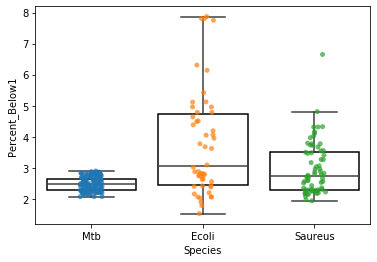

In [56]:
sns.stripplot(x="Species", y="Percent_Below1", data=Asm_Pupmap_Stats_DF, 
              jitter=True, alpha=0.7) 

sns.boxplot(x="Species", y="Percent_Below1", data=Asm_Pupmap_Stats_DF, 
            showcaps=True, boxprops={'facecolor':'none', "edgecolor": "black"}, 
            whiskerprops={'linewidth':1.5}, fliersize=0, linewidth=1.5)  # Transparent boxplot

plt.show()

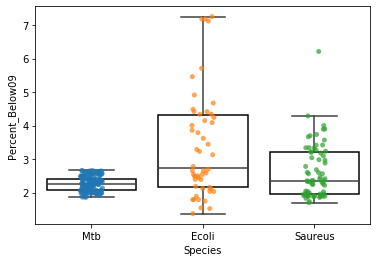

In [58]:
sns.stripplot(x="Species", y="Percent_Below09", data=Asm_Pupmap_Stats_DF, 
              jitter=True, alpha=0.7) 

sns.boxplot(x="Species", y="Percent_Below09", data=Asm_Pupmap_Stats_DF, 
            showcaps=True, boxprops={'facecolor':'none', "edgecolor": "black"}, 
            whiskerprops={'linewidth':1.5}, fliersize=0, linewidth=1.5)  # Transparent boxplot

plt.show()

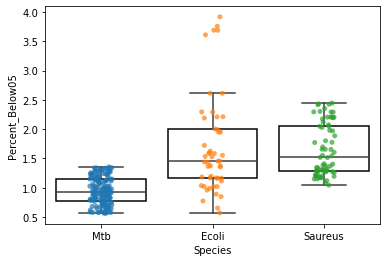

In [59]:

sns.stripplot(x="Species", y="Percent_Below05", data=Asm_Pupmap_Stats_DF, 
              jitter=True, alpha=0.7) 

sns.boxplot(x="Species", y="Percent_Below05", data=Asm_Pupmap_Stats_DF, 
            showcaps=True, boxprops={'facecolor':'none', "edgecolor": "black"}, 
            whiskerprops={'linewidth':1.5}, fliersize=0, linewidth=1.5)  # Transparent boxplot

plt.show()